# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

In [1]:
# Put this in this file to have imported models reload automatically when you edit them.
#!cat ~/.ipython/profile_default/startup/00-autoreload.ipy

In [2]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

In [3]:
# Load the data
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [4]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [5]:
# create standard datasets using all of the MNIST data

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [6]:
from torch.utils.data import WeightedRandomSampler

In [7]:
def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])
    return WeightedRandomSampler(weights, N, replacement=False)

In [8]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

In [9]:
from torch.utils.data import DataLoader

In [10]:
# create standard dataloaders using all of the MNIST data

batch_size = 16

train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [11]:
from tqdm import tqdm

In [12]:
loader_size = 4096

stacked_data_loaders = []
for label in tqdm(range(10)):
    #print(label)
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label], 0.4), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

100%|██████████| 10/10 [01:10<00:00,  7.01s/it]


In [13]:
import federated

In [15]:
learning_rate = 1e-2
num_epochs = 1
num_rounds = 5

#datasets = [train_dloader,
#            train_dloader,
#            train_dloader,            
#            ]

datasets = stacked_data_loaders

manager = federated.FederatedManager(
    datasets,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [16]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) each" )

for i in tqdm(range(num_rounds)):
    print("Beginning round", i)
    manager.round()
    print("    Round: %03d" % i, "Loss: %.5f" % manager.manager_loss_history[-1])

  0%|          | 0/5 [00:00<?, ?it/s]

Training 5 round(s) with 10 worker(s) doing 1 epoch(s) each
Beginning round 0
    Worker: 5728 Epoch:  0
        Worker: 5728 Batch: 000 Loss: 2.3168
        Worker: 5728 Batch: 100 Loss: 2.3399
        Worker: 5728 Batch: 200 Loss: 2.0070
    Worker: 9464 Epoch:  0
        Worker: 9464 Batch: 000 Loss: 2.3137
        Worker: 9464 Batch: 100 Loss: 2.1722
        Worker: 9464 Batch: 200 Loss: 2.2252
    Worker: 696 Epoch:  0
        Worker: 696 Batch: 000 Loss: 2.2556
        Worker: 696 Batch: 100 Loss: 2.1233
        Worker: 696 Batch: 200 Loss: 2.0624
    Worker: 1248 Epoch:  0
        Worker: 1248 Batch: 000 Loss: 2.3058
        Worker: 1248 Batch: 100 Loss: 2.2545
        Worker: 1248 Batch: 200 Loss: 2.2031
    Worker: 8168 Epoch:  0
        Worker: 8168 Batch: 000 Loss: 2.3214
        Worker: 8168 Batch: 100 Loss: 2.3309
        Worker: 8168 Batch: 200 Loss: 1.9071
    Worker: 4352 Epoch:  0
        Worker: 4352 Batch: 000 Loss: 2.3037
        Worker: 4352 Batch: 100 Loss: 2.2232

 20%|██        | 1/5 [01:13<04:52, 73.08s/it]

    Round: 000 Loss: 2.07211
Beginning round 1
    Worker: 5728 Epoch:  0
        Worker: 5728 Batch: 000 Loss: 2.1003
        Worker: 5728 Batch: 100 Loss: 1.8120
        Worker: 5728 Batch: 200 Loss: 1.3427
    Worker: 9464 Epoch:  0
        Worker: 9464 Batch: 000 Loss: 1.9562
        Worker: 9464 Batch: 100 Loss: 1.6795
        Worker: 9464 Batch: 200 Loss: 1.4201
    Worker: 696 Epoch:  0
        Worker: 696 Batch: 000 Loss: 2.0993
        Worker: 696 Batch: 100 Loss: 1.6168
        Worker: 696 Batch: 200 Loss: 1.4686
    Worker: 1248 Epoch:  0
        Worker: 1248 Batch: 000 Loss: 2.1404
        Worker: 1248 Batch: 100 Loss: 1.6904
        Worker: 1248 Batch: 200 Loss: 1.3553
    Worker: 8168 Epoch:  0
        Worker: 8168 Batch: 000 Loss: 2.1528
        Worker: 8168 Batch: 100 Loss: 1.9490
        Worker: 8168 Batch: 200 Loss: 1.5623
    Worker: 4352 Epoch:  0
        Worker: 4352 Batch: 000 Loss: 2.1308
        Worker: 4352 Batch: 100 Loss: 1.8605
        Worker: 4352 Batch: 20

 40%|████      | 2/5 [02:26<03:39, 73.14s/it]

    Round: 001 Loss: 1.35844
Beginning round 2
    Worker: 5728 Epoch:  0
        Worker: 5728 Batch: 000 Loss: 1.2096
        Worker: 5728 Batch: 100 Loss: 0.7565
        Worker: 5728 Batch: 200 Loss: 0.9817
    Worker: 9464 Epoch:  0
        Worker: 9464 Batch: 000 Loss: 1.2891
        Worker: 9464 Batch: 100 Loss: 1.4476
        Worker: 9464 Batch: 200 Loss: 1.1293
    Worker: 696 Epoch:  0
        Worker: 696 Batch: 000 Loss: 1.5291
        Worker: 696 Batch: 100 Loss: 0.9428
        Worker: 696 Batch: 200 Loss: 0.9519
    Worker: 1248 Epoch:  0
        Worker: 1248 Batch: 000 Loss: 1.2915
        Worker: 1248 Batch: 100 Loss: 0.8334
        Worker: 1248 Batch: 200 Loss: 1.0487
    Worker: 8168 Epoch:  0
        Worker: 8168 Batch: 000 Loss: 1.3553
        Worker: 8168 Batch: 100 Loss: 1.1364
        Worker: 8168 Batch: 200 Loss: 1.1181
    Worker: 4352 Epoch:  0
        Worker: 4352 Batch: 000 Loss: 1.5458
        Worker: 4352 Batch: 100 Loss: 0.9885
        Worker: 4352 Batch: 20

 60%|██████    | 3/5 [03:38<02:25, 72.75s/it]

    Round: 002 Loss: 0.80636
Beginning round 3
    Worker: 5728 Epoch:  0
        Worker: 5728 Batch: 000 Loss: 0.6530
        Worker: 5728 Batch: 100 Loss: 0.5508
        Worker: 5728 Batch: 200 Loss: 0.9990
    Worker: 9464 Epoch:  0
        Worker: 9464 Batch: 000 Loss: 0.7308
        Worker: 9464 Batch: 100 Loss: 0.7004
        Worker: 9464 Batch: 200 Loss: 0.4215
    Worker: 696 Epoch:  0
        Worker: 696 Batch: 000 Loss: 0.9195
        Worker: 696 Batch: 100 Loss: 0.6268
        Worker: 696 Batch: 200 Loss: 0.6150
    Worker: 1248 Epoch:  0
        Worker: 1248 Batch: 000 Loss: 0.8090
        Worker: 1248 Batch: 100 Loss: 0.7647
        Worker: 1248 Batch: 200 Loss: 0.9584
    Worker: 8168 Epoch:  0
        Worker: 8168 Batch: 000 Loss: 0.6650
        Worker: 8168 Batch: 100 Loss: 0.5893
        Worker: 8168 Batch: 200 Loss: 0.5703
    Worker: 4352 Epoch:  0
        Worker: 4352 Batch: 000 Loss: 0.6759
        Worker: 4352 Batch: 100 Loss: 0.5751
        Worker: 4352 Batch: 20

 80%|████████  | 4/5 [04:51<01:12, 72.82s/it]

    Round: 003 Loss: 0.58877
Beginning round 4
    Worker: 5728 Epoch:  0
        Worker: 5728 Batch: 000 Loss: 0.7297
        Worker: 5728 Batch: 100 Loss: 0.8732
        Worker: 5728 Batch: 200 Loss: 0.4458
    Worker: 9464 Epoch:  0
        Worker: 9464 Batch: 000 Loss: 0.4785
        Worker: 9464 Batch: 100 Loss: 0.6261
        Worker: 9464 Batch: 200 Loss: 0.6372
    Worker: 696 Epoch:  0
        Worker: 696 Batch: 000 Loss: 0.5558
        Worker: 696 Batch: 100 Loss: 0.5543
        Worker: 696 Batch: 200 Loss: 0.5816
    Worker: 1248 Epoch:  0
        Worker: 1248 Batch: 000 Loss: 0.8830
        Worker: 1248 Batch: 100 Loss: 0.3498
        Worker: 1248 Batch: 200 Loss: 0.6694
    Worker: 8168 Epoch:  0
        Worker: 8168 Batch: 000 Loss: 0.4078
        Worker: 8168 Batch: 100 Loss: 0.4199
        Worker: 8168 Batch: 200 Loss: 0.3853
    Worker: 4352 Epoch:  0
        Worker: 4352 Batch: 000 Loss: 0.9862
        Worker: 4352 Batch: 100 Loss: 0.9504
        Worker: 4352 Batch: 20

100%|██████████| 5/5 [06:12<00:00, 75.38s/it]

    Round: 004 Loss: 0.48996


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

[2.0238099098205566, 2.0721051692962646, 1.399552583694458, 1.358435034751892, 0.8251518607139587, 0.8063560128211975, 0.6213133931159973, 0.5887690186500549, 0.5184746980667114, 0.48995640873908997]
[2.0122385025024414, 2.0721051692962646, 1.3923344612121582, 1.358435034751892, 0.8445345759391785, 0.8063560128211975, 0.6285445094108582, 0.5887690186500549, 0.5130520462989807, 0.48995640873908997]
[2.0811212062835693, 2.0721051692962646, 1.3754466772079468, 1.358435034751892, 0.8205777406692505, 0.8063560128211975, 0.6046343445777893, 0.5887690186500549, 0.5154334306716919, 0.48995640873908997]
[2.1017725467681885, 2.0721051692962646, 1.3739187717437744, 1.358435034751892, 0.8347784876823425, 0.8063560128211975, 0.6044511795043945, 0.5887690186500549, 0.5257554054260254, 0.48995640873908997]
[2.10681414604187, 2.0721051692962646, 1.3674421310424805, 1.358435034751892, 0.8215932846069336, 0.8063560128211975, 0.6197519302368164, 0.5887690186500549, 0.5085564851760864, 0.48995640873908997

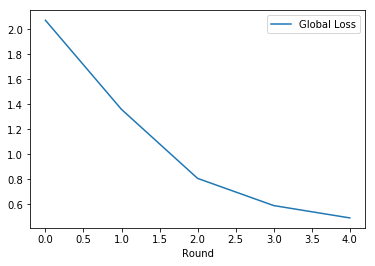

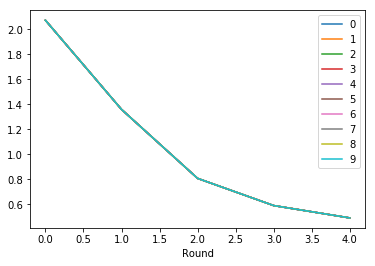

In [19]:
fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="Global Loss")
ax.set_xlabel("Round");
ax.legend();

# loss of fig, ax = plt.subplots(5, 2)
fig, ax = plt.subplots()
ax.set_xlabel("Round")
for i in range(len(manager.worker_loss_histories)):
    
    print(manager.worker_loss_histories[i])
    ax.plot(manager.worker_loss_histories[i][1::2], label=i)
    lbl = "Worker " + str(i)

ax.legend();

## MLW: WHY DOES THE LAST WORKER SHOW UP FIRST IN THE LEGEND?

In [ ]:
## TODO - need to get the stacked decks combined to train a common model with all of them. It's not a fair comparison to have the non-federated approach exposed to the entire MNIST set, while the cumulative federated workers get less.

